In [2]:
import numpy as np
import qutip as qt
import scipy.stats as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import random

In [4]:
def generate_prior_ginibre(n):
    # draw n states from the ginibre distribution (unbiased)
    s = [qt.sigmax(), qt.sigmay(), qt.sigmaz()] 
    x_0 = np.zeros((n, 3))
    w_0 = np.ones(n)/n
    for i in range(n):
        dm = qt.rand_dm_ginibre(dim)
        x_0[i] = np.array([qt.expect(j, dm) for j in s]) # calculate pauli representation
    return x_0, w_0

def measurement(rho, c):
    # create a measurement outcome of the state rho (in pauli representation) when measured in basis c
    prob = (np.sum(rho * c)+1)/2
    if random.uniform(0, 1) < prob: res = 1
    else: res = 0
    return res

def experiment(rho, c, rep):
    # measure rho pauli basises specified in c, repear ech measurement rep times, return # of measuered 1s
    c_rep = np.tile(c, [1, rep]).reshape((len(c) * rep, 3)) # repeated measurements
    d_rep = np.array([measurement(rho, c_i) for c_i in c_rep]) # generate random measurements on rho     
    return np.sum(np.reshape(d_rep, (len(c), meas_rep)), axis= 1) # sum over measurement repetitions

def pauli_measurement_basis(n):
    # create n random unit vectors
    c_basis = np.random.randint(0, 3, n) # random measurement basis
    c = np.zeros((n, 3))
    for idc, c_i in enumerate(c_basis): c[idc][c_i] = 1 # create measurement vectors
    return c

def haarrand_measurement_basis(n):
    # create n haar random bloch vectors of unit length
    c = np.zeros((n, 3))
    s = [qt.sigmax(), qt.sigmay(), qt.sigmaz()] 
    for i in range(n):
        dm = qt.ket2dm(qt.rand_ket_haar(2))
        c[i] = np.array([qt.expect(j, dm) for j in s])
    return c
    
def likelihood(x, d, c, rep):
    # calculate likelihood of measurement outcome d given that the state is x
    p = [(np.sum(x_i * c) + 1) / 2 for x_i in x]
    return np.array([sp.binom.pmf(d, rep, p[i]) for i in range(len(x))])

def update_weights(x, w, d, c, rep):
    # update weights according to likelihood and normalize, check whether resampling is required
    w_new = w * likelihood(x, d, c, rep)
    w_new = np.divide(w_new, np.sum(w_new))
    n_eff = 1 / np.sum(w_new**2)
    if n_eff / len(w) < thr_resampling: resampling_required = 1
    else: resampling_required = 0
    return w_new, resampling_required

def pointestimate(x, w):
    # return point estimate of rho
    return np.average(x, axis=0, weights= w)

def resample_lw(x, w, h= 0.14, a= 0.99):
    # resampling points from x with weights w according to Liu and West algorithm
    x_out = []
    mu = pointestimate(x, w)
    cov = h**2 * np.cov(x, aweights= w, rowvar= 0)
    for i in range(len(x)):
        j = np.random.choice(len(x), p= w)
        mu_i = a * x[j] + (1 - a) * mu
        valid_state = 0
        while valid_state == 0:
            temp = np.random.multivariate_normal(mu_i, cov)
            if np.sum(temp**2) <= 1: valid_state = 1
        x_out.append(temp)
    w_out = np.divide(np.ones(len(x)), len(x))
    return np.array(x_out), w_out

def fidelity(a, b):
    # compute fidelity from density matrices in Pauli representation
    s = [qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    a_dm = 1/2 * qt.qeye(2)
    b_dm = 1/2 * qt.qeye(2)
    for ids, s_i in enumerate(s):
        a_dm += 1/2 * (s_i * a[ids])
        b_dm += 1/2 * (s_i * b[ids])
    return qt.metrics.fidelity(a_dm, b_dm)

def plot2D_samples(x, w, rho=None, rho_est=None, r= 0.02, proj= [0, 1], scale= 0.1, size= (10, 10)):
    # plot sample points
    fig = plt.figure(figsize=(size)) 
    plt.gca().add_patch(plt.Circle((0, 0), 1, ec='black', fc=None, fill= 0)) 
    plt.scatter(x[:,proj[0]], x[:,proj[1]], s= w * len(w) * scale)
    if (rho is not None) and (rho_est is not None):
        confidence_ellipse(x.T[proj], w, rho_est, plt.gca(), n_std=3.0)
        plt.scatter(rho[proj[0]], rho[proj[1]], c='red', s=400 * scale)
        plt.scatter(rho_est[proj[0]], rho_est[proj[1]], c='orange', s= 400 * scale, marker= 'X')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.show()
    
def confidence_ellipse(x, w, rho_est, ax, n_std=3.0, fc='none', ec='orange', **kwargs):
    # create confidence ellipse, n_std = 3.0 cooresponds to 98.5% confidence interval
    cov = np.cov(x, aweights= w)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, fc= fc, ec= ec, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(rho_est[0], rho_est[1])
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [5]:
n_q = 1 # number of Qubits - fixed in this implementation
dim = 2**n_q # Dimension of Hilbert space

# ideal state
rho = np.array([0.7, 0.3, 0])

# Experiments in Pauli basis
n_meas = 50 # number of measurements
meas_rep = 16 # number of repetitions of measurement
c_meas = haarrand_measurement_basis(n_meas) # create bloch vectors of measurement basis

# SMC parameters
n = 2000 # number of sampling points
thr_resampling = 0 # resampling threshold
a = 0.99 # resampling parameter
h = np.sqrt(1-a**2) # [a^2+h^2=1] makes sure the resampled covariance stays the same
flag_resampling = 0 # resampling required

[0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
[2.84348891e-03 6.90478949e-04 2.29636164e-06 ... 3.20620811e-07
 2.44811466e-03 7.71826600e-15]
[4.92348788e-03 8.23617123e-04 2.14534906e-06 ... 2.97548969e-07
 3.98637138e-03 8.47908712e-18]
[2.38190165e-05 4.45550165e-04 5.03664344e-06 ... 2.85297583e-09
 9.20431387e-03 2.06541854e-17]
[3.06351646e-05 5.23890509e-05 3.92248776e-10 ... 5.39818499e-14
 6.65201845e-03 1.21756854e-31]
[1.21549813e-05 1.20621841e-08 5.20976505e-14 ... 3.84262122e-24
 1.50510728e-03 1.04946352e-35]
[3.94732131e-05 3.14060205e-08 2.15643013e-14 ... 1.20811542e-23
 3.53334358e-03 7.26006619e-40]
[4.11794058e-06 5.70751714e-09 1.07559122e-15 ... 3.69749817e-28
 3.61275266e-03 2.19261576e-44]
[4.80160514e-08 1.62510690e-13 1.23474416e-18 ... 2.06575400e-43
 5.58617251e-04 2.08068164e-47]
[1.96848858e-11 1.80501466e-13 8.25374118e-20 ... 3.27721216e-43
 8.25081693e-04 2.71499031e-59]
[1.11222541e-11 7.27445425e-14 2.42444824e-19 ... 1.17913284e-46
 2.39993951e-0

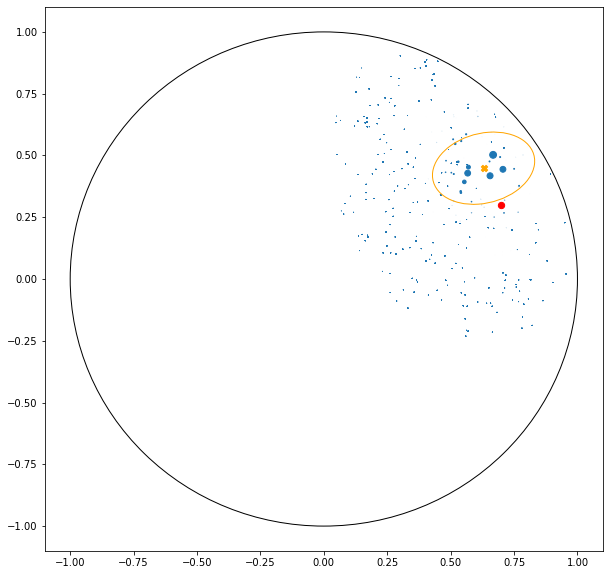

In [6]:
# Experiments
d_meas = experiment(rho, c_meas, meas_rep)

# Generate particle cloud according to unbiased ginibre prior
x, w = generate_prior_ginibre(n)
print(w)

# Update the sequential Monte Carlo particle cloud
for i in range(n_meas):
    w, flag_resampling = update_weights(x, w, d_meas[i], c_meas[i], meas_rep)
    print(w)
    if flag_resampling == 1:
        x, w = resample_lw(x, w, h= h, a= a)
        flag_resampling = 0

# Estimates
rho_est = pointestimate(x, w)
loss = fidelity(rho_est, rho)
cov = np.cov(x, aweights= w, rowvar= 0)
print(rho_est)
print(loss)

# Plot particle cloud
plot2D_samples(x, w, rho, rho_est)

In [5]:
#number of qubits
l = 2000

# number of measurements
n_meas_arr = np.array([1, 10, 100, 1000])

# ideal state
rho = np.array([0.7, 0.3, 0])

# Experiments in Pauli basis
meas_rep = 16 # number of repetitions of measurement
n_exp = 10

fid = np.zeros((2, len(n_meas_arr), n_exp))

#empirical estimation
fid_emp = np.zeros((2, len(n_meas_arr), n_exp))

for iexp in range(n_exp):
    print(iexp)
    x_0, w_0 = generate_prior_ginibre(l) # Generate particle cloud according to unbiased ginibre prior
    rho = generate_prior_ginibre(1)[0][0] # state to estimate
    # Pauli Measurements
    c_meas_p = pauli_measurement_basis(n_meas_arr[-1])
    # Pauli Measurements
    c_meas_hr = haarrand_measurement_basis(n_meas_arr[-1])
    c_all = [c_meas_p, c_meas_hr]
    for idc, c in enumerate(c_all):
        d = experiment(rho, c, meas_rep)
        for idn, n_i in enumerate(n_meas_arr):
            x, w = x_0, w_0
            w_sum = np.zeros(l)
            for i in range(n_i):
                w, flag_resampling = update_weights(x, w, d[i], c[i], meas_rep)
                emp_likelihood = likelihood(x_0, d[i], c[i], meas_rep)
                w_sum += emp_likelihood / np.sum(emp_likelihood)
                if flag_resampling == 1:
                    x, w = resample_lw(x, w, h= h, a= a)
                    flag_resampling = 0
            fid[idc][idn][iexp] += fidelity(pointestimate(x, w), rho)
            fid_emp[idc][idn][iexp] += fidelity(pointestimate(x_0, w_sum / l), rho)
            
np.savetxt('fid.txt', np.reshape(fid, (-1)))
np.savetxt('fid_emp.txt', np.reshape(fid_emp, (-1)))

0


KeyboardInterrupt: 

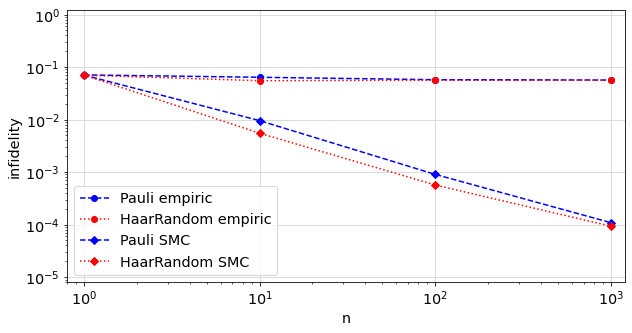

In [119]:
fig = plt.figure(figsize=(10, 5))
plt.plot(n_meas_arr, 1- np.mean(fid_emp[0], axis=1), label='Pauli empiric', ls='--', marker='o', c='blue')
plt.plot(n_meas_arr, 1 -np.mean(fid_emp[1], axis=1), label='HaarRandom empiric', ls=':', marker='o', c='red')
plt.plot(n_meas_arr, 1- np.mean(fid[0], axis=1), label='Pauli SMC', ls='--', marker='D', c='blue')
plt.plot(n_meas_arr, 1 -np.mean(fid[1], axis=1), label='HaarRandom SMC', ls=':', marker='D', c='red')
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.ylim(0.000008, 1.2)
plt.xlim(0.8, 1200)
plt.xlabel('n', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.ylabel('infidelity', fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid(c='lightgray')
plt.legend(fontsize='x-large')
plt.show()